# TestFourierTransform

## FFT of waveform

Import necessary modules

In [1]:
import numpy as np
import scipy as sc
import scipy.fft as scfft
import matplotlib.pyplot as plt
import uproot

In [2]:
from Functions import *

In [6]:
CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(23,740)

In [19]:
print(CombinedFile.keys())
print('---------------')
print(CombinedFile['combined'].show(name_width=60))

['info;1', 'combined;1']
---------------
name                                                         | typename                 | interpretation                
-------------------------------------------------------------+--------------------------+-------------------------------
waveforms                                                    | mattak::Waveforms        | AsGroup(<TBranchElement 'wa...
waveforms/mattak::IWaveforms                                 | (group of TObject:(gr... | AsGroup(<TBranchElement 'ma...
waveforms/mattak::IWaveforms/TObject                         | (group of fUniqueID:u... | AsGroup(<TBranchElement 'TO...
waveforms/mattak::IWaveforms/TObject/fUniqueID               | uint32_t                 | AsDtype('>u4')
waveforms/mattak::IWaveforms/TObject/fBits                   | uint8_t                  | AsDtype('uint8')
waveforms/mattak::IWaveforms/run_number                      | uint32_t                 | AsDtype('>u4')
waveforms/mattak::IWaveforms/event_nu

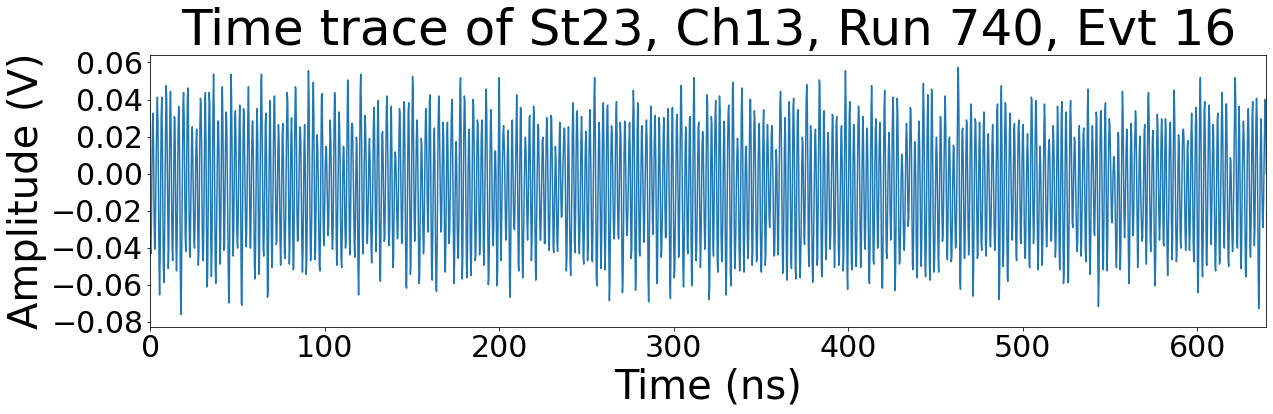

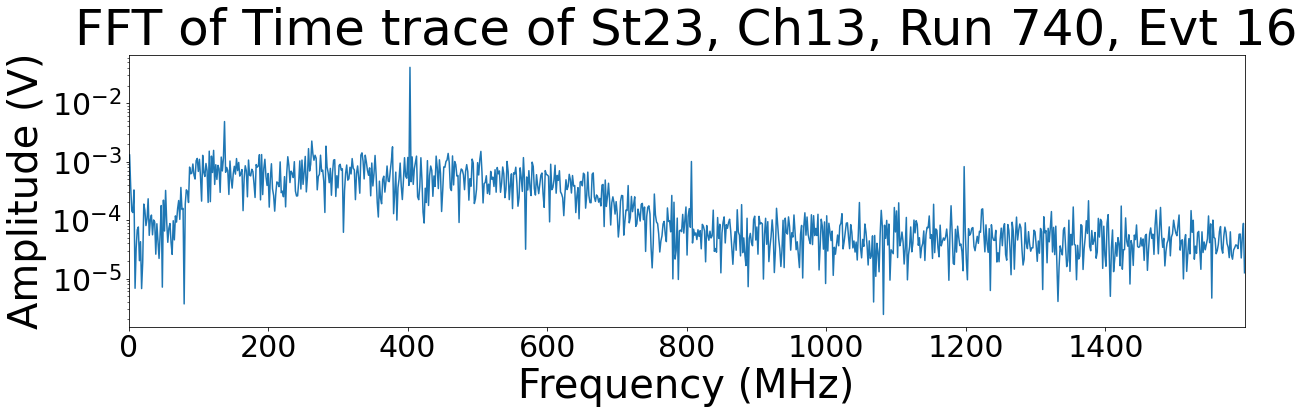

In [3]:
TimeTrace(23,13,740,16,Amplitude="V")
TimeTraceFFT(23,13,740,16,Amplitude="V",LogScale=True)

In [6]:
CmbFile=GetCombinedFile(22,712)
CmbFile['combined'].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
waveforms            | mattak::Waveforms        | AsGroup(<TBranchElement 'wa...
waveforms/TObject    | (group of fUniqueID:u... | AsGroup(<TBranchElement 'TO...
waveforms/TObject... | uint32_t                 | AsDtype('>u4')
waveforms/TObject... | uint8_t                  | AsDtype('uint8')
waveforms/run_number | uint32_t                 | AsDtype('>u4')
waveforms/event_n... | uint32_t                 | AsDtype('>u4')
waveforms/station... | uint16_t                 | AsDtype('>u2')
waveforms/buffer_... | uint16_t                 | AsDtype('>u2')
waveforms/radiant... | int16_t[24][2048]        | AsDtype("('>i2', (24, 2048))")
header               | mattak::Header           | AsGroup(<TBranchElement 'he...
header/TObject       | (group of fUniqueID:u... | AsGroup(<TBranchElement 'TO...
header/TObject/fU... | uint32_t          

def FilesStRun(StNr,RunNr):
    path=Path(StNr,RunNr)
    CombinedFile=uproot.open(path+"/combined.root")
    DAQStatFile=uproot.open(path+"/daqstatus.root")
    HeadersFile=uproot.open(path+"/headers.root")
    PedestalFile=uproot.open(path+"/pedestal.root")
    return CombinedFile, DAQStatFile, HeadersFile, PedestalFile

def DailyVoltAvg(StNr,ChNr,Runs,NBins=24,ZeroAvg=True,TimeFormat="LST",Triggers=(5,5,5,5),StdCut=-1,FFTFilter=True,Lowpass=False):
    """
    Plots the Average V_RMS as a function of time of the day.
    Parameters:
    StNr,ChNr,Runs=Station number, channel number, list of runs 
    NBins=amount of bins to divide the full day in
    ZeroAvg=Boolean: if true, the timetraces will firs tbe zero averaged
    Lowpass= Boolean: if true, a butterworth lowpass filter will be applied in order to maintain only galactic noise dominated frequencies
    FFTFilter=Boolean: if true, applies a Notch filter to all frequency spectra to cut out frequencies which have shown to be potentially problematic
    TimeFormat= String: Dictates what timeformat the x-axis will be in. Options: "LST": local sidereal time, "LT": Local time & "UTC": UTC time
    Triggers=tupel of flags to dictate which triggers are allowed in the analysis. Events with different triggers are not used (0=has to be absent, 1=has to be present, anything else=both 0 and 1 can be used for analysis)
    StdCut=if larger than zero, all VRMS outliers above StdCut standard variations will be cut out of the analysis
    """
    (has_rf,has_ext,has_pps,has_soft)=Triggers
    NEvs=0
    EventRMS=np.array([]) #Array to store V_RMS value of each event
    EventTime=np.array([])#Array to store timestamp of each event
    #for (Run, EvNr) in TriggerFilterAlt(StNr, ChNr, Runs,has_rf,has_ext,has_pps,has_soft):
    for (Run,EvNr) in TriggerFilterAlt(StNr, ChNr, Runs,has_rf,has_ext,has_pps,has_soft):
        path=Path(StNr,Run)
        #if os.path.isdir(path+"/combined.root"):
        if os.path.isfile(path+"/combined.root") and os.path.isfile(path+"/daqstatus.root"):
            NEvs+=1
        
            CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
            RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
            EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
            TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np')        
                
            EvIndex=np.where(EventNrs==EvNr)[0][0]
            VoltageTrace=ADCtoVoltage(RadiantData[EvIndex][ChNr]) #The timetrace data in voltage
            if ZeroAvg==True:
                Vmean=np.mean(VoltageTrace)
                VoltageTrace-=Vmean
                #EventRMS=np.append(EventRMS,np.sqrt(np.mean([(V-Vmean)**2 for V in ADCtoVoltage(RadiantData[EvIndex][ChNr])])))
            if FFTFilter or Lowpass:
                sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
                TimeStep=1/sampling_rate #Time between two samples
                SamplingTimes=np.arange(0,len(RadiantData[0][0])*TimeStep,TimeStep)
                freq=scfft.fftfreq(len(SamplingTimes),(SamplingTimes[-1]-SamplingTimes[0])/len(SamplingTimes))
                freq=np.fft.fftshift(freq)
                TotalFilter=np.ones(len(freq))
                if FFTFilter:
                    TotalFilter=np.multiply(TotalFilter,NotchFilters([403*10**6,120*10**6,807*10**6,1197*10**6],75,freq,sampling_rate))
                if Lowpass:
                    CritFreq=110*10**6
                    TotalFilter=np.multiply(TotalFilter,LowpassButter(CritFreq,20,freq))
                FFT=scfft.fft(VoltageTrace)
                FFT=np.fft.fftshift(FFT)
                FFT=np.array([FFT[i]*TotalFilter[i] for i in range(len(freq))])
                VoltageTrace=np.abs(scfft.ifft(FFT))
            
            EventRMS=np.append(EventRMS,np.sqrt(np.mean([V**2 for V in VoltageTrace])))
                
            if TimeFormat=="LST":
                EventTime=np.append(EventTime,LST(TriggerTimes,EvIndex))
            elif TimeFormat=="LT": #Greenland Timezone is UTC-3
                EventTime=np.append(EventTime,(UTC(TriggerTimes,EvIndex)-3)%24)
            else:
                print("Please enter a valid TimeFormat")
                return

In [ ]:
runs, evnrs=np.empty(), np.empty()